# Spectral Parameterization
## 02 - Real Data and Event-Related Analysis
In this notebook, we will apply the techniques we learned from the previous notebooks and apply our spectral parameterization toolbox on real data.

## Basic Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # high res plotting

import numpy as np
import scipy as sp

from scipy import signal
from scipy import io

from neurodsp import spectral
from neurodsp import filt
from neurodsp import sim

from fooof import FOOOF

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})

In [2]:
from neurodsp.spectral import compute_spectrum

## Load Data

This data is an electrocorticogram (ECoG) recording, which is an intracranial recording of electrical signals from the brain.

This is a single channel in the visual cortex.

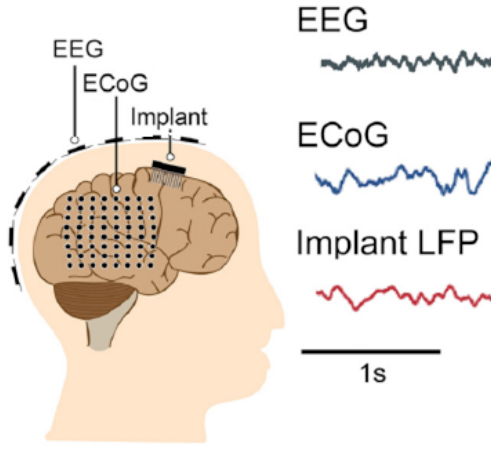

In [3]:
# We are setting the sampling frequency here. The data is sampled at 1000 Hz.
fs = 1000 

# Load the channel and the event indicces.
data = io.loadmat('data/ecog_data.mat', squeeze_me=True)
sta = data['sta'] # Standard event
tar = data['tar'] # Target event
resp = data['resp'] # Response
data = data['data'] # Neural data from one ECoG channel

## Visualize Data

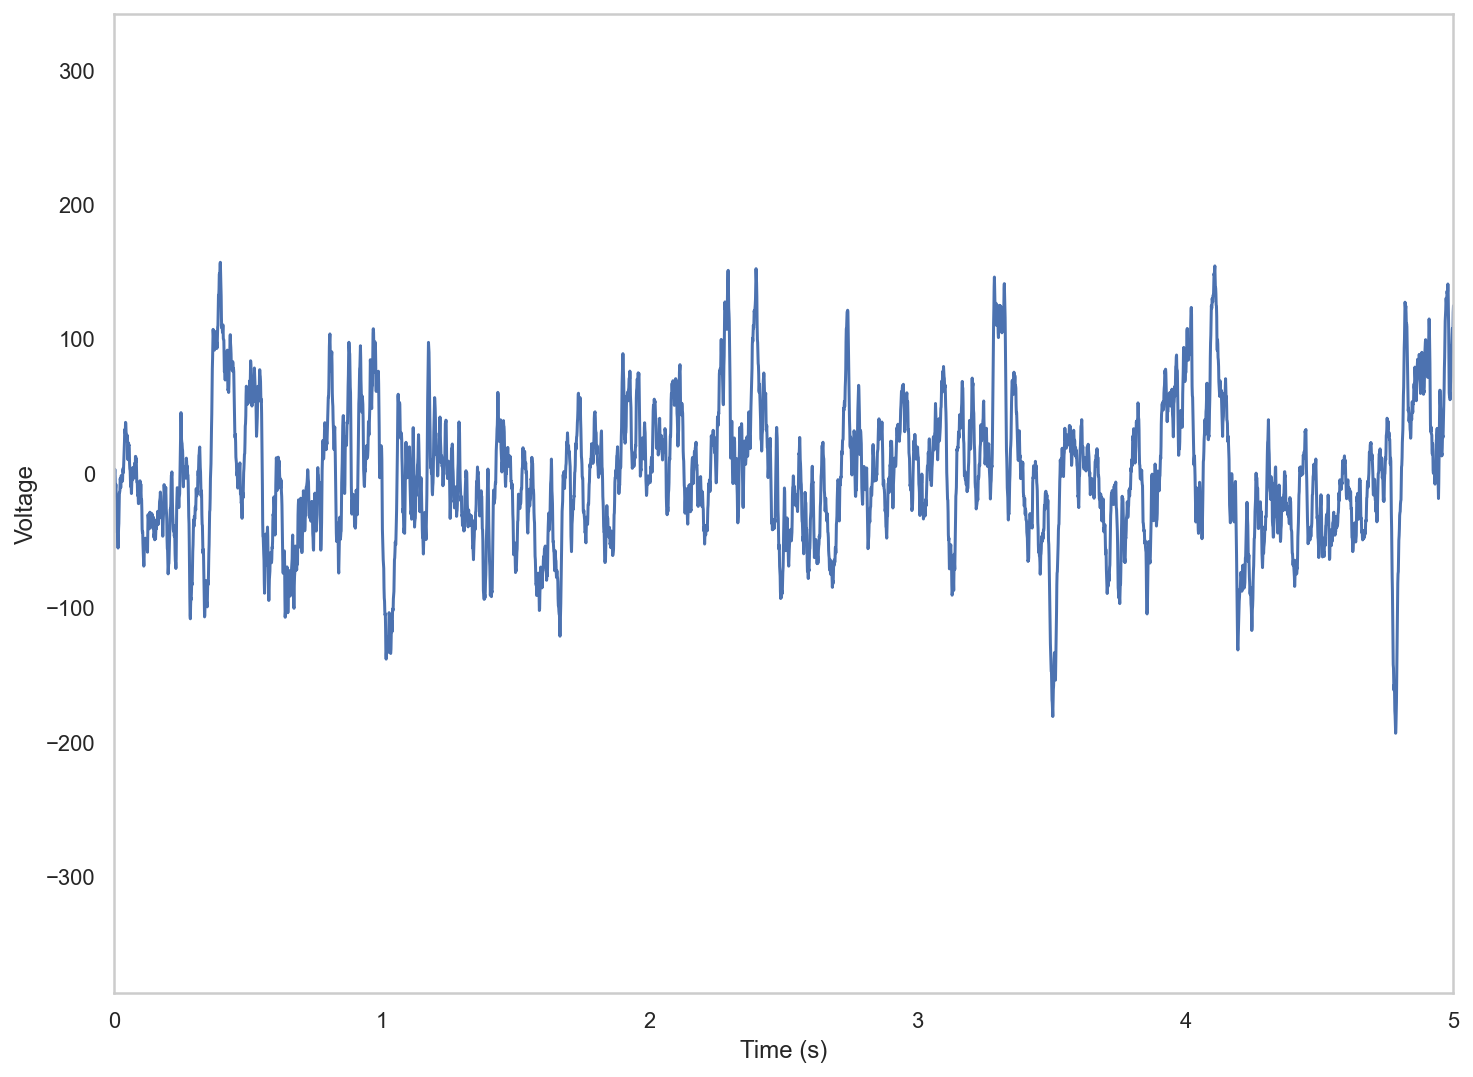

In [4]:
# Plot a section of the data in the time domain.
t = np.arange(len(data))/fs
plt.plot(t, data)
plt.xlim((0,5))
plt.xlabel('Time (s)')
plt.ylabel('Voltage')
plt.show()

In [5]:
# Compute power spectra for both conditions
freq_c1, psd_c1 = compute_spectrum(condition_1, fs=fs, method='welch')
freq_c2, psd_c2 = compute_spectrum(condition_2, fs=fs, method='welch')

NameError: name 'condition_1' is not defined

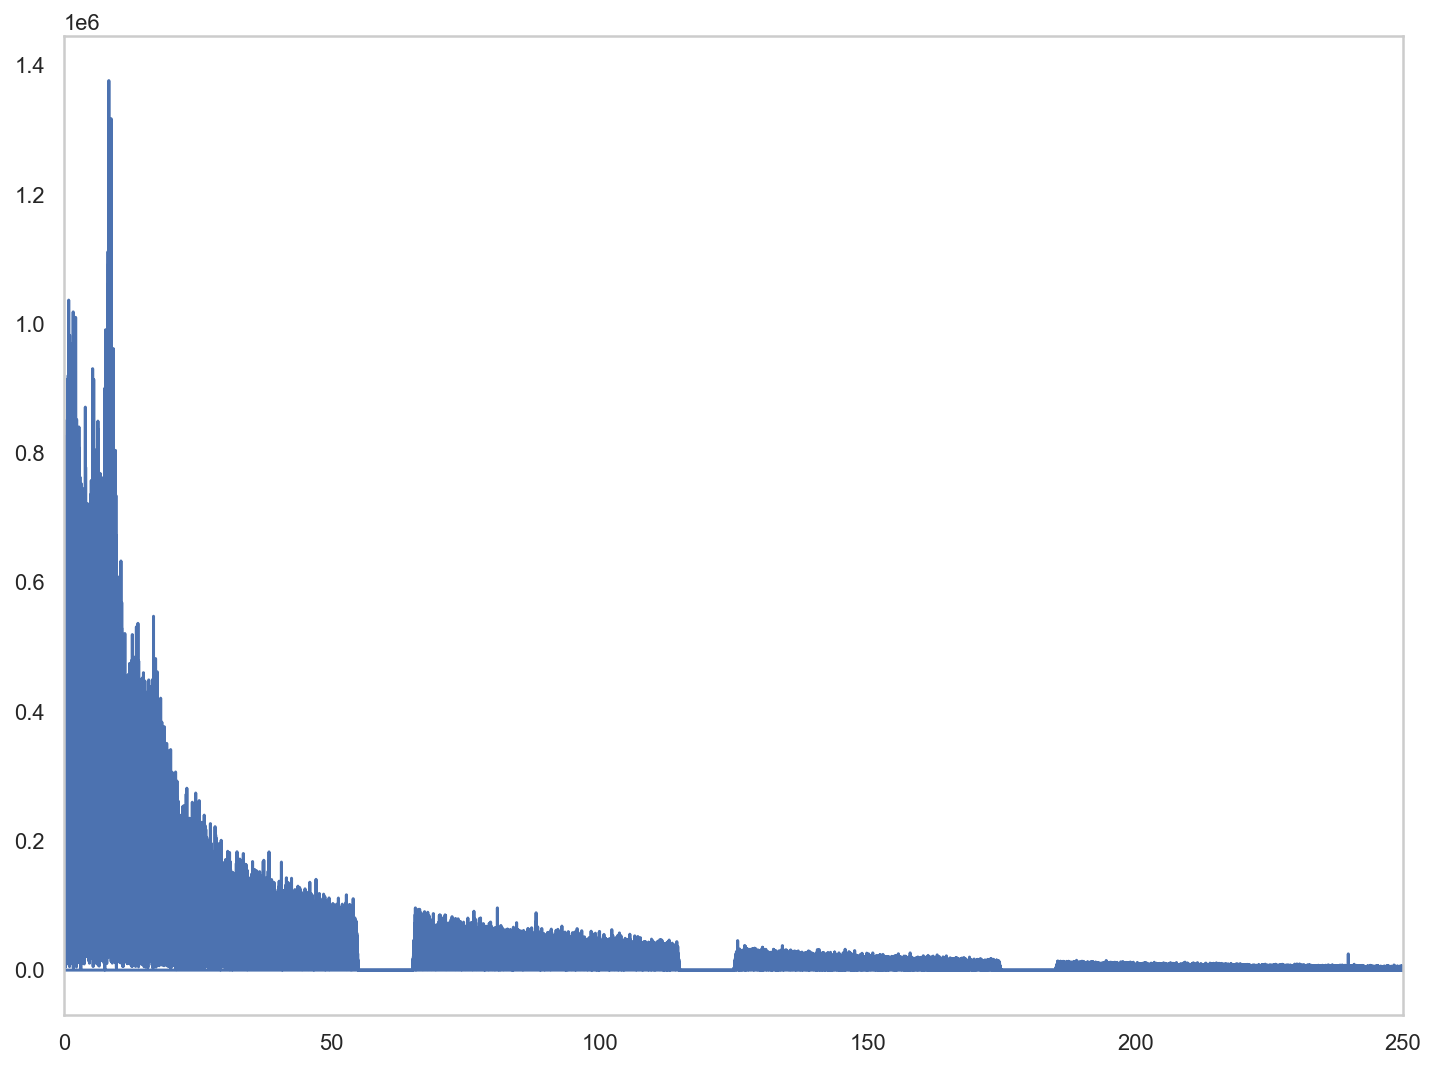

In [6]:
# Plot the power spectrum of the data in the frequency domain.
sp = np.abs(np.fft.fft(data)) # Power Spectrum
freq = np.fft.fftfreq(data.shape[-1])*fs # Frequencies

plt.plot(freq, sp)
plt.xlim((0, 250))
plt.show()

## generate PSD
## fit the PSD
## explore different parameters
## event related

Epoch data in windows around event onset
See if aperiodic changes due to the event
Could also do band power analysis
Plot ERP's of alpha filtered data

Two windows pre/post
Power changes 

As contrast look at aperiodic changes

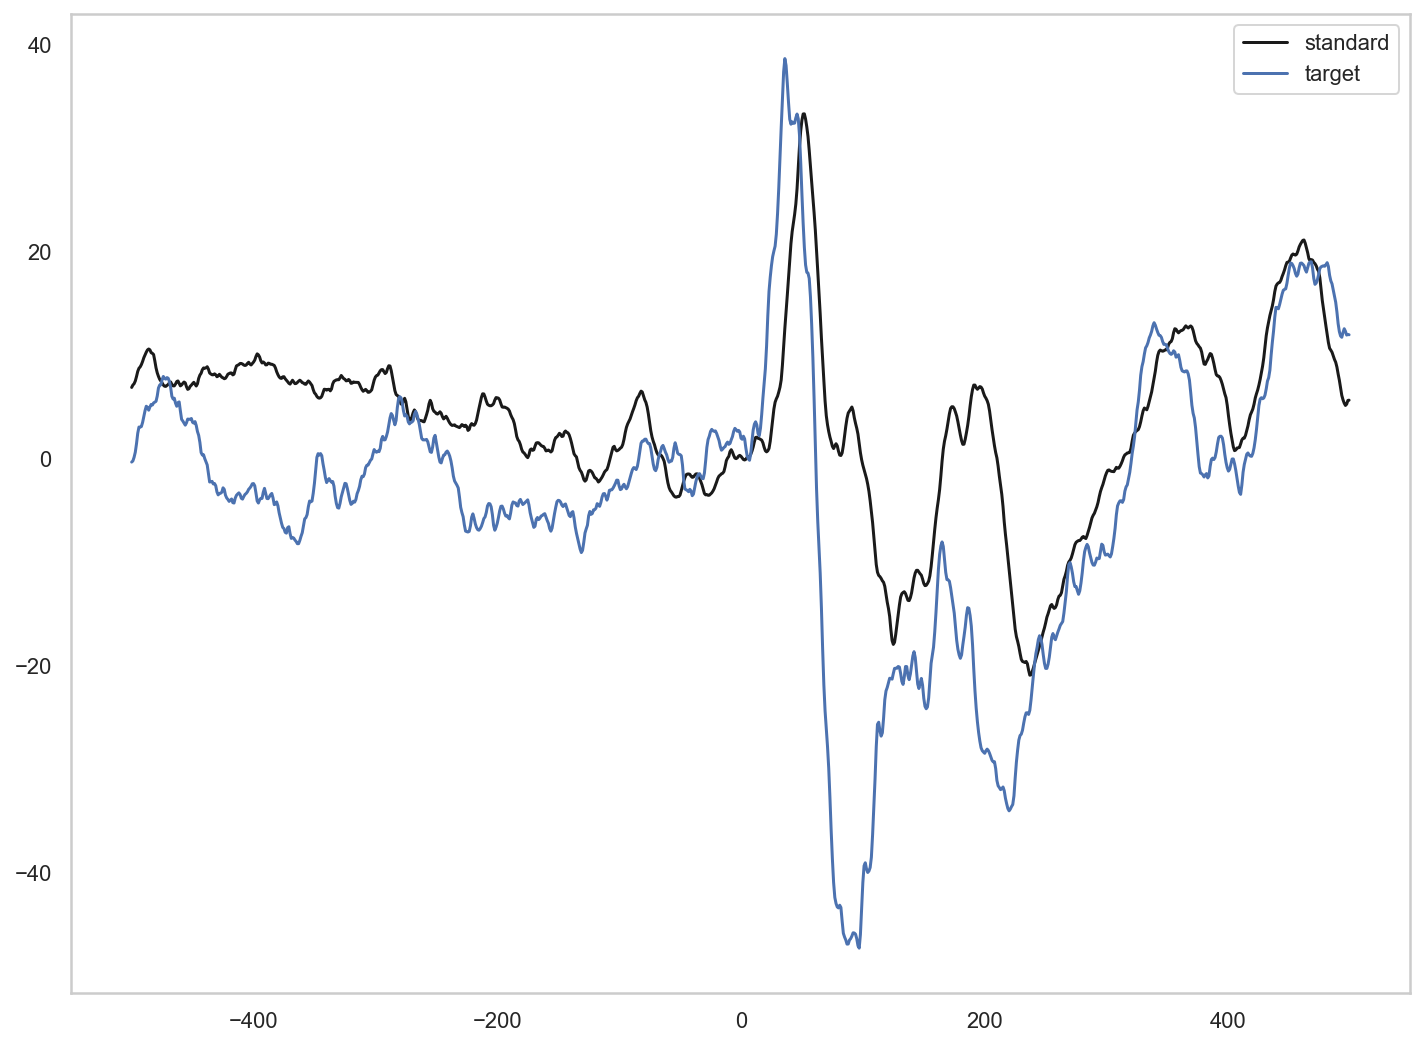

In [9]:
def event_related(data, fs, indices, window, subtract_mean=None):
    """Take an input time series, vector of event indices, and window sizes,
    and return a 2d matrix of windowed trials around the event indices.
    
    Parameters
    ----------
    data : array-like 1d
        Voltage time series
    data : float
        Data sampling rate (Hz)
    indices : array-like 1d of integers
        Indices of event onset indices
    window : tuple (intengers)
        Window (in ms) around event onsets
    subtract_mean : tuple (intengers), optional
        if present, subtract the mean value in the subtract_mean window for each
        trial from that trial's time series (this is a trial-by-trial baseline)
    
    Returns
    -------
    event_related_matrix : array-like 2d
        Event-related times series around each index
        Each row is a separate event
    """
    
    # convert times (in ms) to indices of points along the array
    def windows_to_indices(fs, window_times):
        conversion_factor = (1/fs)*1000 # convert from time points to ms
        window_times = np.floor(np.asarray(window_times)/conversion_factor) # coonvert
        window_times = window_times.astype(int) # turn to ints
        
        return window_times
    
    window_idx = windows_to_indices(fs, window) # convert times (in ms) to indices
    inds = indices + np.arange(window_idx[0],window_idx[1])[:,None] # build matrix of indices
    event_times = np.arange(window[0], window[1], fs/1000)
    
    event_related_matrix = data[inds] # grab the data
    event_related_matrix = np.squeeze(event_related_matrix).T # make sure it's in the right format
    
    # baseline, if requested
    if subtract_mean is not None:
        basewin = [0,0]
        basewin[0] = np.argmin(np.abs(event_times-subtract_mean[0]))
        basewin[1] = np.argmin(np.abs(event_times-subtract_mean[1]))
        event_related_matrix = event_related_matrix - event_related_matrix[:, basewin[0]:basewin[1]].mean(axis=1, keepdims=True)
    
    return event_times, event_related_matrix

event_times, sta_erp = event_related(data, fs, sta, (-500,500), (-100,0))
event_times, tar_erp = event_related(data, fs, tar, (-500,500), (-100,0))

plt.plot(event_times, np.mean(sta_erp,0), 'k', label='standard')
plt.plot(event_times, np.mean(tar_erp,0), 'b', label='target')
plt.legend()
plt.show()

From this plot, it looks like the onset of the target and standard stimuli produce a large event-related potential (ERP) and that these ERPs might differ depending on the experimental condition. However, when we think about the contributions of aperiodic activity to neural signals, we're left with several questions:

1) Does aperiodic activity change in an event-related way?  
2) How might changes in aperiodic activity be affecting our interpretations of event-related changes in band power?  
3) Could aperiodic activity be changing differentially according to behavioral condition?  

To quantify this, we'll start with a basic pre- vs. post- event analysis. We'll divide the data into two windows--2 seconds pre-event onset, and 2 seconds post-event onset--, calcualte power spectra for these two windows, and compare spectral features. 

In [83]:
# compute event windows with no baseline
event_times, pre_sta_erp = event_related(data, fs, sta, (-1*fs,0))
event_times, post_sta_erp = event_related(data, fs, sta, (0,1*fs))
event_times, pre_tar_erp = event_related(data, fs, tar, (-1*fs,0))
event_times, post_tar_erp = event_related(data, fs, tar, (0,1*fs))

In [92]:
# caclcualte power spectra for 2 time windows and 2 conditions
freqs, pre_sta_psd = spectral.compute_spectrum_welch(pre_sta_erp, fs, nperseg=fs*1, noverlap=fs/2, f_range=[2,52])
freqs, post_sta_psd = spectral.compute_spectrum_welch(post_sta_erp, fs, nperseg=fs*1, noverlap=fs/2, f_range=[2,52])
freqs, pre_tar_psd = spectral.compute_spectrum_welch(pre_tar_erp, fs, nperseg=fs*1, noverlap=fs/2, f_range=[2,52])
freqs, post_tar_psd = spectral.compute_spectrum_welch(post_tar_erp, fs, nperseg=fs*1, noverlap=fs/2, f_range=[2,52])

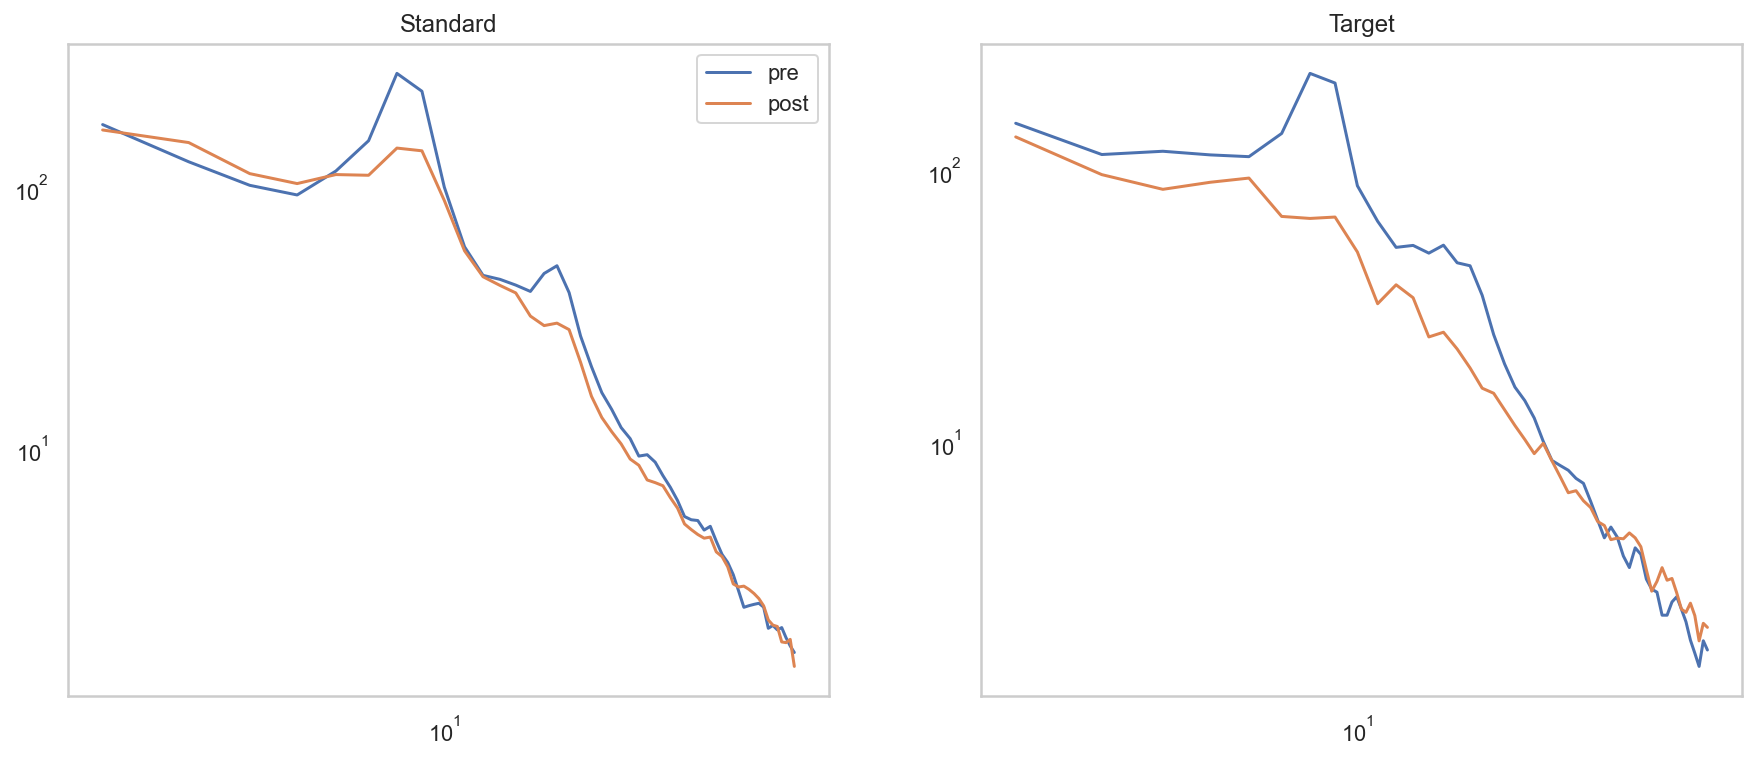

In [93]:
# plot raw psds

fig, ax = plt.subplots(1,2, figsize=[15,6])
ax = ax.ravel()

ax[0].plot(freqs, pre_sta_psd.mean(axis=0), label='pre')
ax[0].plot(freqs, post_sta_psd.mean(axis=0), label='post')

ax[1].plot(freqs, pre_tar_psd.mean(axis=0), label='pre')
ax[1].plot(freqs, post_tar_psd.mean(axis=0), label='post')

ax[0].set_title('Standard')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].set_title('Target')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

I dont' think this analysis really adds much--the high gamma change really was only for a few hundred milliseconds...


What about baselined vs. unbaselined? -- PROBABLY WON"T INCLUDE THIS 

In [94]:
# compute event windows with no baseline
event_times, sta_erp = event_related(data, fs, sta, (-2*fs,2*fs))
event_times, tar_erp = event_related(data, fs, tar, (-2*fs,2*fs))


# compute event windows with baseline
event_times, sta_erp_base = event_related(data, fs, sta, (-2*fs,2*fs), (-100,0))
event_times, tar_erp_base = event_related(data, fs, sta, (-2*fs,2*fs), (-100,0))

In [95]:
# caclcualte power spectra for 2 time windows and 2 conditions
freqs, sta_psd = spectral.compute_spectrum_welch(sta_erp, fs, nperseg=fs*2, noverlap=fs, f_range=[1,250])
freqs, tar_psd = spectral.compute_spectrum_welch(tar_erp, fs, nperseg=fs*2, noverlap=fs, f_range=[1,250])
freqs, sta_psd_base = spectral.compute_spectrum_welch(sta_erp_base, fs, nperseg=fs*2, noverlap=fs, f_range=[1,250])
freqs, tar_psd_base = spectral.compute_spectrum_welch(tar_erp_base, fs, nperseg=fs*2, noverlap=fs, f_range=[1,250])

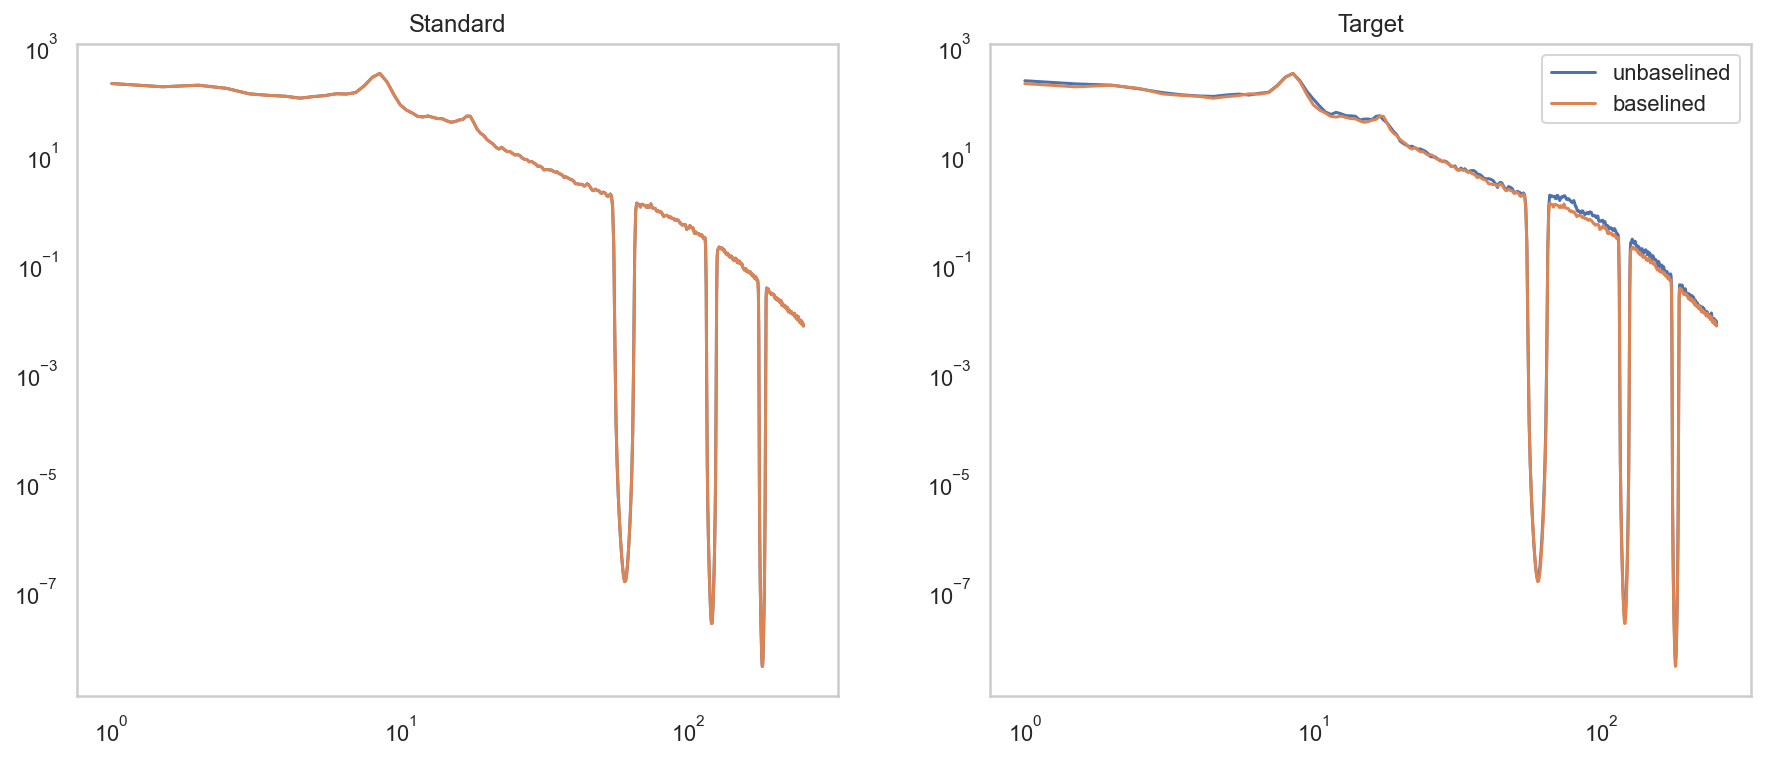

In [96]:
# plot raw psds

fig, ax = plt.subplots(1,2, figsize=[15,6])
ax = ax.ravel()

ax[0].plot(freqs, sta_psd.mean(axis=0), label='unbaselined')
ax[0].plot(freqs, sta_psd_base.mean(axis=0), label='baselined')

ax[1].plot(freqs, tar_psd.mean(axis=0), label='unbaselined')
ax[1].plot(freqs, tar_psd_base.mean(axis=0), label='baselined')

ax[0].set_title('Standard')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_title('Target')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()

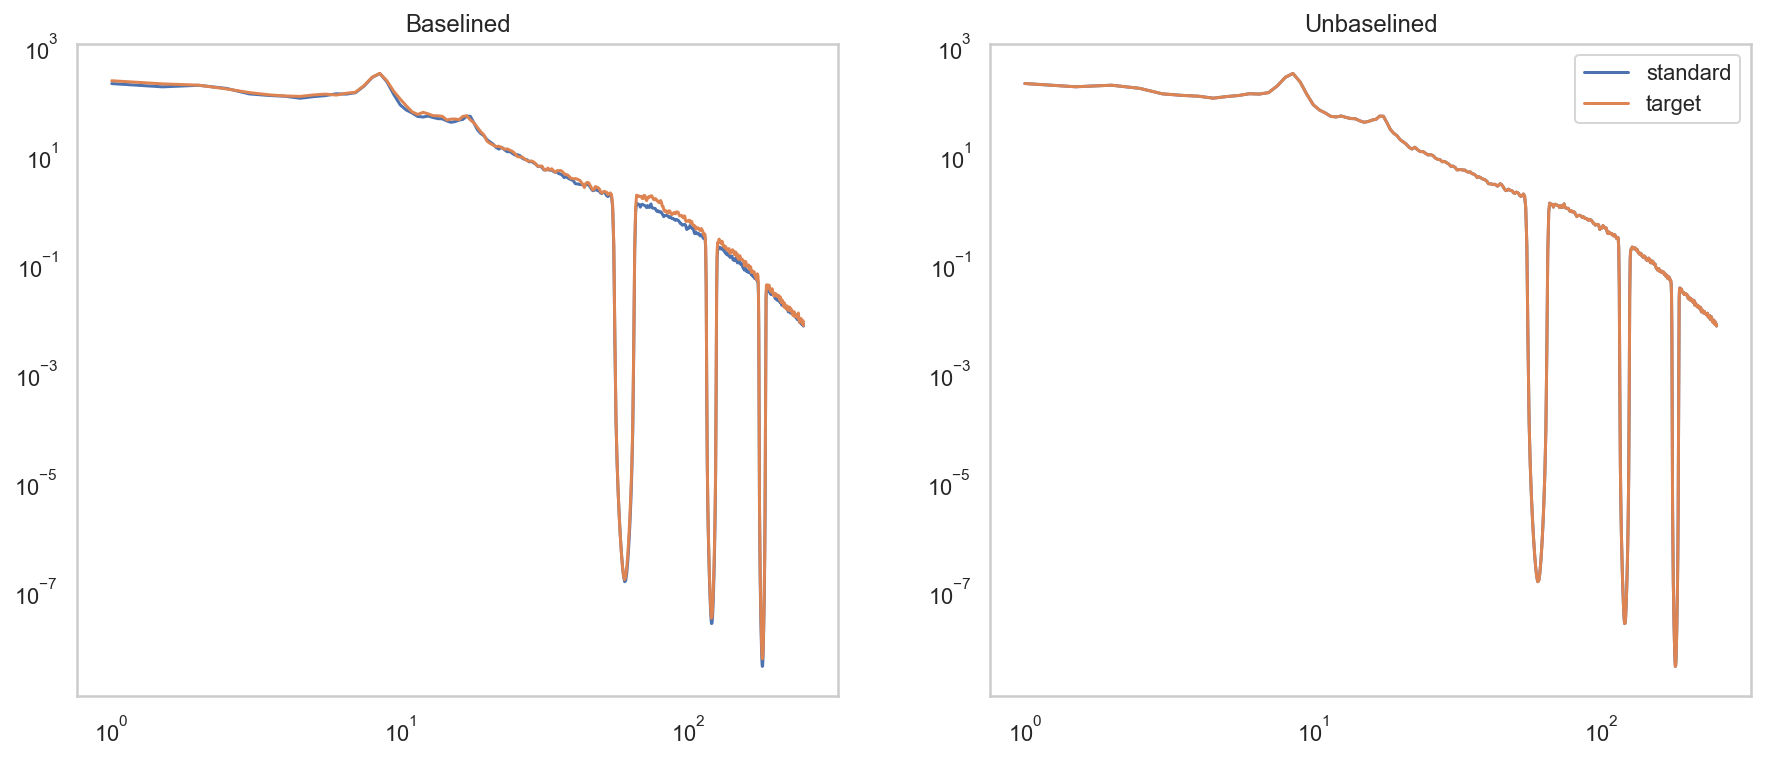

In [97]:
# plot raw psds

fig, ax = plt.subplots(1,2, figsize=[15,6])
ax = ax.ravel()

ax[0].plot(freqs, sta_psd.mean(axis=0), label='standard')
ax[0].plot(freqs, tar_psd.mean(axis=0), label='target')

ax[1].plot(freqs, sta_psd_base.mean(axis=0), label='standard')
ax[1].plot(freqs, tar_psd_base.mean(axis=0), label='target')

ax[0].set_title('Baselined')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_title('Unbaselined')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].legend()

Aperiodic activity can also change dynamically, but we'll look at this in another tutorial.